In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix

# pca
from sklearn.decomposition import PCA

import os

## Read data

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()                

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.shape

(299, 13)

## Data Split

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

In [5]:
FEATURES = ['age', 'ejection_fraction', 'serum_creatinine', 'time']

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

## Preprocessing

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SVC

In [7]:
# kernel rbf
svc_rbf = SVC(kernel='rbf', random_state=42)
# kernel poly; degree 3
svc_poly = SVC(kernel='poly', degree=3, random_state=42)
# kernel linear
svc_linear = SVC(kernel='linear', random_state=42)
# kernel sigmoid
svc_sigmoid = SVC(kernel='sigmoid', random_state=42)

svcs = [svc_rbf, svc_poly, svc_linear, svc_sigmoid]
print("Training SVM models without PCA...\n\n")
for svc in svcs:
    
    svc.fit(X_train_scaled, y_train)
    y_pred = svc.predict(X_test_scaled)
    print(f"Classifier {svc}")
    print(f"Accuracy : ", accuracy_score(y_test, y_pred))
    print(f"ROC-AUC ", roc_auc_score(y_test, y_pred))
    #plt.figure(figsize=(3,3))
    #cf_matrix = confusion_matrix(y_test, y_pred)
    #sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    #plt.show()
    print("-"*100)
    print()

Training SVM models without PCA...


Classifier SVC(random_state=42)
Accuracy :  0.8
ROC-AUC  0.7406931964056483
----------------------------------------------------------------------------------------------------

Classifier SVC(kernel='poly', random_state=42)
Accuracy :  0.7833333333333333
ROC-AUC  0.6861360718870345
----------------------------------------------------------------------------------------------------

Classifier SVC(kernel='linear', random_state=42)
Accuracy :  0.8166666666666667
ROC-AUC  0.7528883183568679
----------------------------------------------------------------------------------------------------

Classifier SVC(kernel='sigmoid', random_state=42)
Accuracy :  0.7666666666666667
ROC-AUC  0.6880616174582799
----------------------------------------------------------------------------------------------------



## Hyperparameter Tuning

In [8]:
params = {
    'C': [0.01, 0.05, 0.50, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 5, 10],
}

model = SVC(random_state=42)

clf = GridSearchCV(model,
                   param_grid=params,
                   n_jobs=-1,
                   verbose=2)

clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished


GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.5, 1, 10], 'degree': [3, 5, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

In [9]:
print("Optimal Hyperparameter: ", clf.best_estimator_)

Optimal Hyperparameter:  SVC(C=0.5, kernel='linear', random_state=42)


In [10]:
clf_best = clf.best_estimator_

y_pred = clf_best.predict(X_test_scaled)

print(f"Accuracy : ", accuracy_score(y_test, y_pred))
print(f"ROC-AUC ", roc_auc_score(y_test, y_pred))

Accuracy :  0.8166666666666667
ROC-AUC  0.7528883183568679


## PCA

In [11]:
# applying PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [12]:
pca.explained_variance_ratio_

array([0.33051984, 0.25576625])

In [13]:
# plotting PCA
def plot_pca(X, y, axes, title="XYZ"):
    plt.plot(X[y == 0, 0], X[y == 0, 1], 'bo')
    plt.plot(X[y == 1, 0], X[y == 1, 1], 'ro')
    plt.axis(axes)
    plt.title(title, fontsize=(16))
    plt.legend(loc=2);

In [14]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

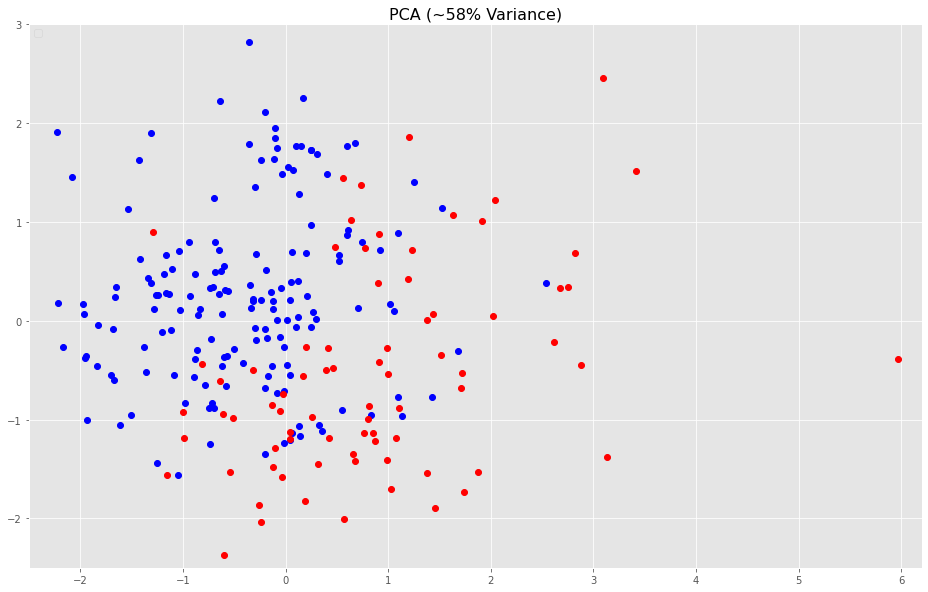

In [15]:
plt.figure(figsize=(16,10))
plot_pca(X_train_pca, y_train, axes=[-2.5, 6.2, -2.5, 3], title="PCA (~58% Variance)")

In [16]:
# svc rbf
svc_rbf = SVC(kernel='rbf', random_state=42)
# kernel poly; degree 3
svc_poly = SVC(kernel='poly', degree=3, C=5, coef0=100, random_state=42)
# kernel linear
svc_linear = SVC(kernel='linear', random_state=42)
# kernel sigmoid
svc_sigmoid = SVC(kernel='sigmoid', random_state=42)

svc_rbf.fit(X_train_pca, y_train)
svc_poly.fit(X_train_pca, y_train)
svc_linear.fit(X_train_pca, y_train)
svc_sigmoid.fit(X_train_pca, y_train)

SVC(kernel='sigmoid', random_state=42)

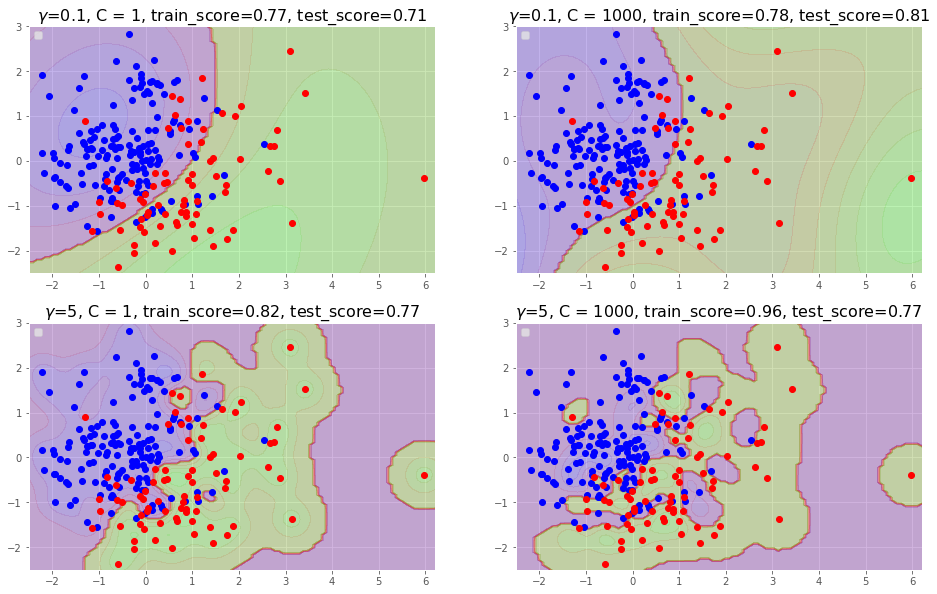

In [17]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 1, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svc_rbfs = []
for gamma, C in hyperparams:
    rbf_kernel_svc = SVC(kernel="rbf", gamma=gamma, C=C)
    rbf_kernel_svc.fit(X_train_pca, y_train)
    svc_rbfs.append(rbf_kernel_svc)

plt.figure(figsize=(16,10))
for i, svc_rbf in enumerate(svc_rbfs):
    plt.subplot(221 + i)
    plot_predictions(svc_rbf, axes=[-2.5, 6.2, -2.5, 3])
    plot_pca(X_train_pca, y_train, axes=[-2.5, 6.2, -2.5, 3], title="")
    y_pred_train = svc_rbf.predict(X_train_pca)
    y_pred_test = svc_rbf.predict(X_test_pca)
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    gamma, C = hyperparams[i]
    plt.title(f"$\gamma$={gamma}, C = {C}, train_score={roc_auc_train:.2f}, test_score={roc_auc_test:.2f}", fontsize=16)
    
plt.show()

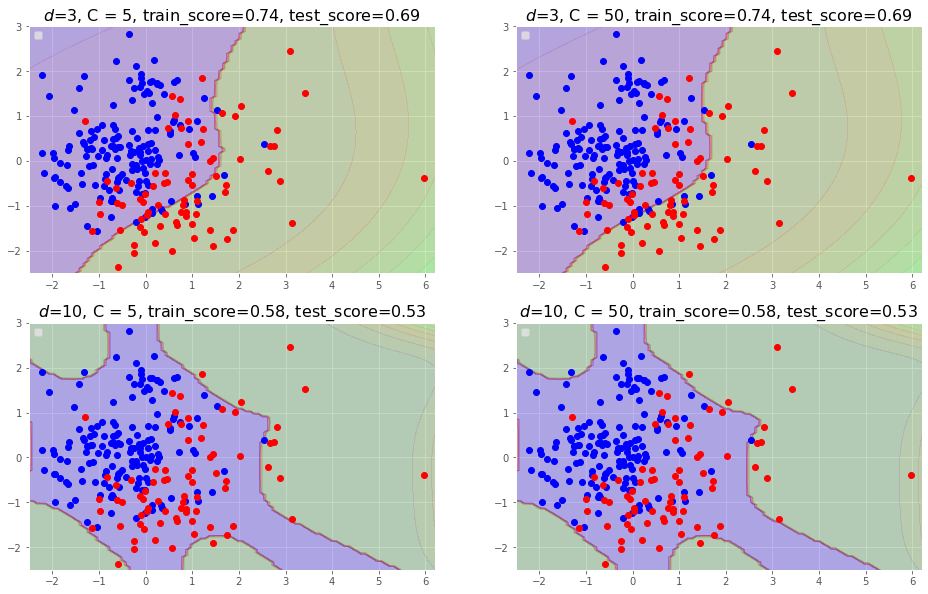

In [18]:
degree1, degree2 = 3, 10
C1, C2 = 5, 50
hyperparams = (degree1, C1), (degree1, C2), (degree2, C1), (degree2, C2)

svc_polys = []
for degree, C in hyperparams:
    poly_svc = SVC(kernel="poly", degree=degree, C=C)
    poly_svc.fit(X_train_pca, y_train)
    svc_polys.append(poly_svc)

plt.figure(figsize=(16,10))
for i, svc_poly in enumerate(svc_polys):
    plt.subplot(221 + i)
    plot_predictions(svc_poly, axes=[-2.5, 6.2, -2.5, 3])
    plot_pca(X_train_pca, y_train, axes=[-2.5, 6.2, -2.5, 3], title="")
    y_pred_train = svc_poly.predict(X_train_pca)
    y_pred_test = svc_poly.predict(X_test_pca)
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    d, C = hyperparams[i]
    plt.title(f"$d$={d}, C = {C}, train_score={roc_auc_train:.2f}, test_score={roc_auc_test:.2f}", fontsize=16)
    
plt.show()

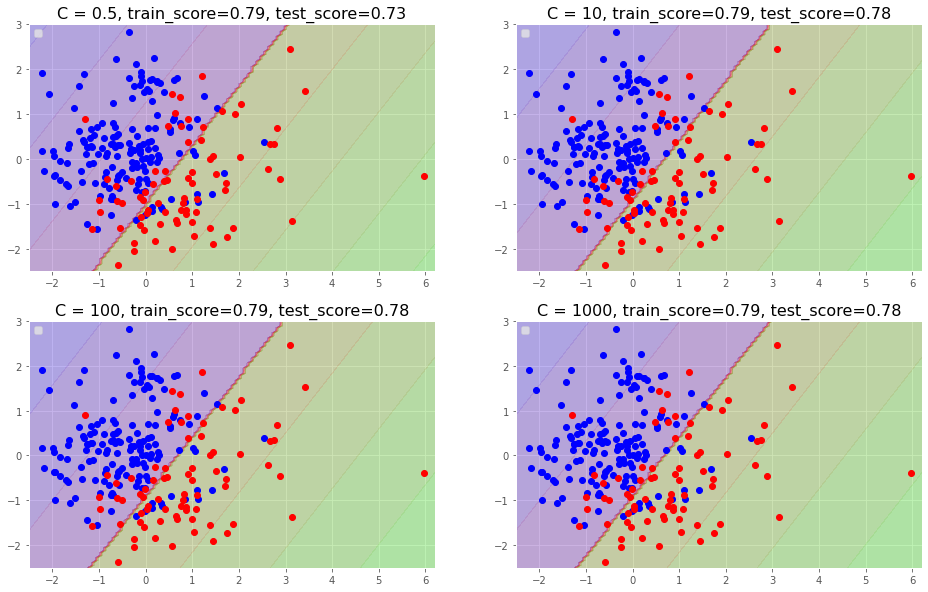

In [19]:
C1, C2, C3, C4 = 0.5, 10, 100, 1000
hyperparams = C1, C2, C3, C4

svc_lins = []
for C in hyperparams:
    linear_svc = SVC(kernel="linear", C=C)
    linear_svc.fit(X_train_pca, y_train)
    svc_lins.append(linear_svc)

plt.figure(figsize=(16,10))
for i, svc_lin in enumerate(svc_lins):
    plt.subplot(221 + i)
    plot_predictions(svc_lin, axes=[-2.5, 6.2, -2.5, 3])
    plot_pca(X_train_pca, y_train, axes=[-2.5, 6.2, -2.5, 3], title="")
    y_pred_train = svc_lin.predict(X_train_pca)
    y_pred_test = svc_lin.predict(X_test_pca)
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    C = hyperparams[i]
    plt.title(f"C = {C}, train_score={roc_auc_train:.2f}, test_score={roc_auc_test:.2f}", fontsize=16)
    
plt.show()

## Grid Search PCA

In [20]:
params = {
    'C': [0.01, 0.05, 0.50, 1, 10, 100, 500, 1000],
    'kernel': ['linear', 'rbf'],
    'gamma' : [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}

model = SVC(random_state=42)

clf = GridSearchCV(model,
                   param_grid=params,
                   n_jobs=-1,
                   verbose=10)

clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0089s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0365s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0274s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0525s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1181s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1628s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapse

GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.5, 1, 10, 100, 500, 1000],
                         'gamma': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
                         'kernel': ['linear', 'rbf']},
             verbose=10)

In [21]:
print("Optimal Hyperparameter: ", clf.best_estimator_)

Optimal Hyperparameter:  SVC(C=100, gamma=0.01, kernel='linear', random_state=42)


In [22]:
clf_best = clf.best_estimator_

y_pred = clf_best.predict(X_test_pca)

print(f"Accuracy : ", accuracy_score(y_test, y_pred))
print(f"ROC-AUC ", roc_auc_score(y_test, y_pred))

Accuracy :  0.8166666666666667
ROC-AUC  0.7811296534017972


## Extras

Text(0, 0.5, 'Losses')

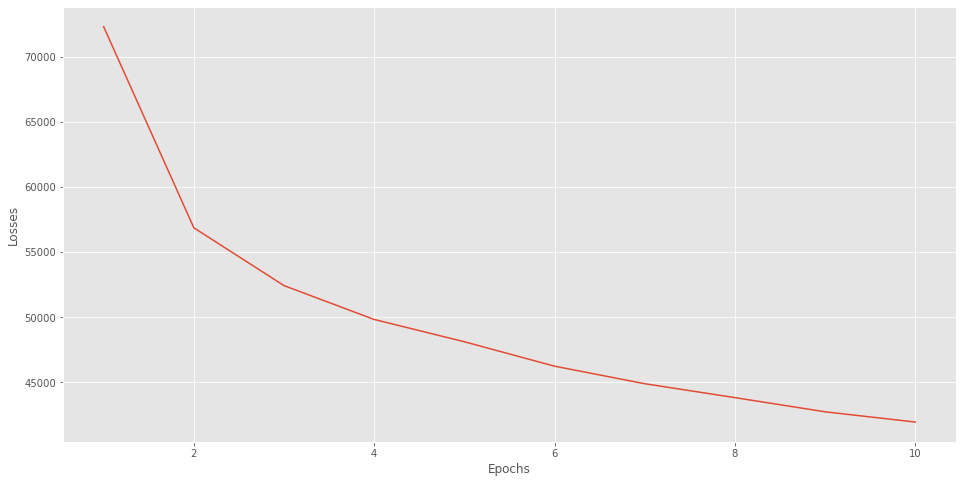

In [23]:
losses = [72298.94619296206, 56868.940236335344, 52432.60245189024, 49835.23851474888,
          48124.861916189926, 46250.34075868717, 44905.51279853745, 43838.40086841049,
          42750.57473929, 41965.642965581705]

epochs = [1,2,3,4,5,6,7,8,9,10]

plt.figure(figsize=(16,8))
sns.lineplot(epochs, losses)
plt.xlabel("Epochs")
plt.ylabel("Losses")